In [1]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from torch.utils.data import DataLoader
from syndatagenerators.data_preparation.lsm_data import LSMDataset

In [2]:
file_ids = [5, 6, 7, 8, 9]
n_files = len(file_ids)
cat_columns = ['LCLid']
# cont_columns = ['Summer_Time', 'Year_Sin', 'Year_Cos', 'Week_Sin', 'Week_Cos', 'Day_Sin', 'Day_Cos']
cont_columns = ['Day_Sin', 'Day_Cos']
target_columns = ['KWH_per_half_hour']
embedding_dim = 2

batch_size = 16

In [3]:
dataset = LSMDataset(
    store_path='../../data/londonSmartMeter.h5', 
    file_ids=file_ids ,
    cat_columns=cat_columns,
    cont_columns=cont_columns,
    target_columns=target_columns,
    load_df=False)

train_size = int(0.05 * len(dataset))
test_size = len(dataset) - train_size
dataset_train, dataset_test = torch.utils.data.random_split(dataset, [train_size, test_size])

dl_train = DataLoader(
    dataset=dataset_train, 
    batch_size=batch_size, 
    shuffle=True, 
    drop_last=True)

dl_test = DataLoader(
    dataset=dataset_test, 
    batch_size=batch_size, 
    shuffle=False, 
    drop_last=True)

100%|██████████| 5/5 [00:00<00:00,  9.08it/s]


In [4]:
len(dataset), len(dataset_train), len(dataset_test)

(2504, 125, 2379)

torch.Size([16, 48, 1]) torch.Size([16, 48, 2]) torch.Size([16, 48, 1])


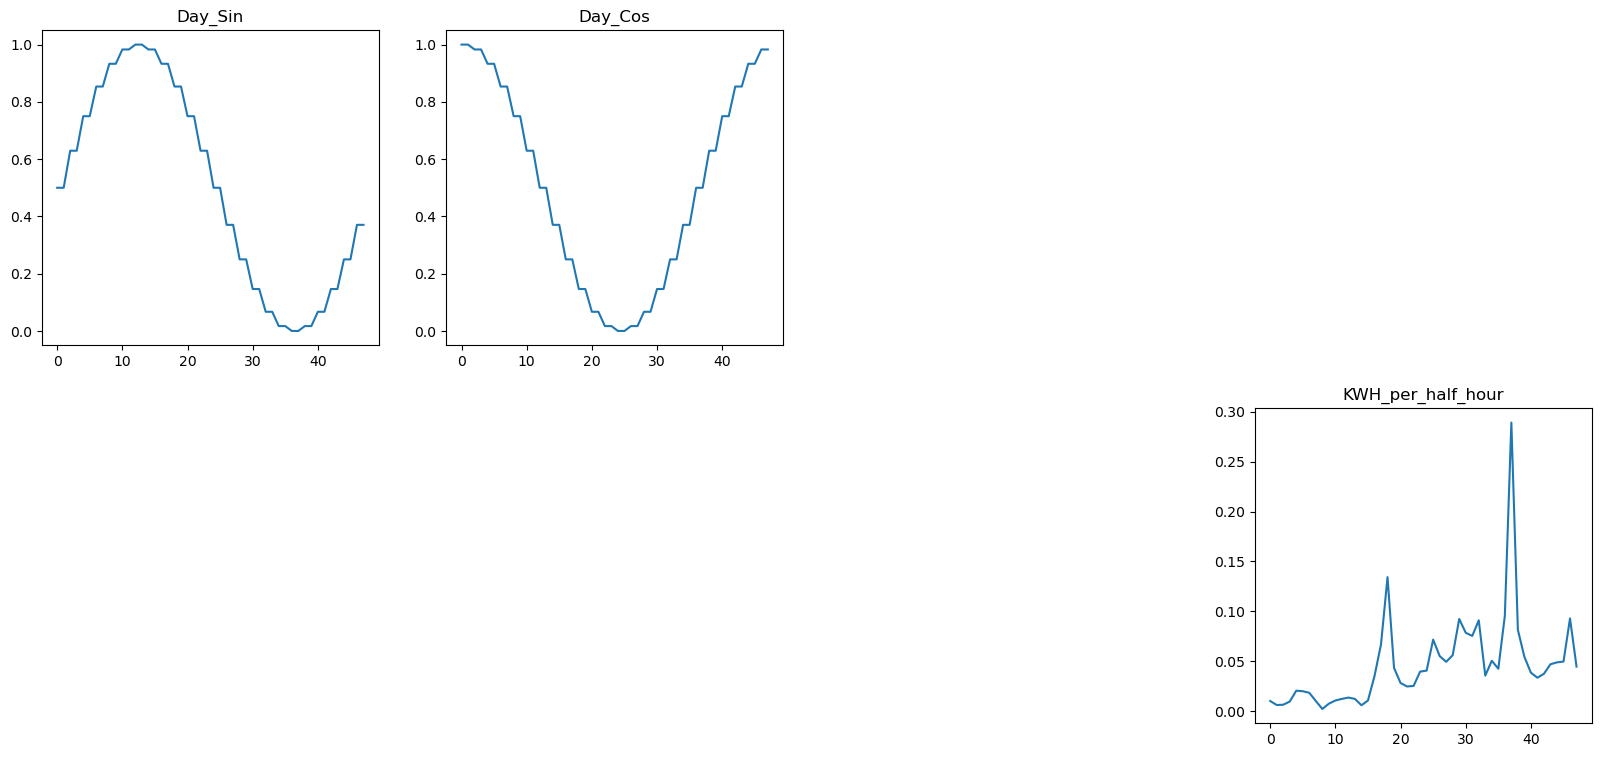

In [5]:
for x_cat, x_cont, y in dl_train:
    print(x_cat.shape, x_cont.shape, y.shape)
    break

plt.figure(figsize=(20, 9))
for plt_id in range(len(cont_columns)):
    plt.subplot(2, 4, plt_id+1)
    plt.plot(x_cont[0, :, plt_id])
    plt.title(cont_columns[plt_id])
plt.subplot(2, 4, 8)
plt.title(target_columns[0])
plt.plot(y[0, :, 0])
plt.show()

In [6]:
def mse(y, y_pred):
    loss_fct = nn.BCELoss()
    mse = loss_fct(y, y_pred)
    return mse
    
class Basic_MLP(nn.Module):
    def __init__(self, n_cont):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_cont, 16), nn.ReLU(),
            nn.Linear(16, 32), nn.ReLU(),
            nn.Linear(32, 64), nn.ReLU(),
            nn.Linear(64, 1), nn.ReLU()) 
        
    def forward(self, x_cont):
        y = self.net(x_cont)
        return y
    
    def evaluate(self, dl, device):
        logits_all, targets_all = [], []
        for _, x_cont, y in dl:
            x_cont = x_cont.to(device)
            y = y.to(device)
            with torch.no_grad():
                logits = self.forward(x_cont)
            logits_all.append(logits)
            targets_all.append(y)
        logits_all = torch.cat(logits_all, dim=0)
        targets_all = torch.cat(targets_all, dim=0)
        error = mse(logits_all, targets_all).item()
        return error
    
class Embedding_MLP(nn.Module):
    def __init__(self, n_cont, num_embeddings=n_files, embedding_dim=2, layer_scaling=1):
        super().__init__()
        self.emb = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim)
        self.net = nn.Sequential(
            nn.Linear(embedding_dim+n_cont, 16), nn.ReLU(), nn.Dropout(),
            nn.Linear(16, 32*layer_scaling), nn.ReLU(), nn.Dropout(),
            nn.Linear(32*layer_scaling, 64*layer_scaling), nn.ReLU(), nn.Dropout(),
            nn.Linear(64*layer_scaling, 1), nn.ReLU()) 
        
    def forward(self, x_cat, x_cont):
        x = torch.cat([self.emb(x_cat).flatten(2), x_cont], dim=-1)
        y = self.net(x)
        return y
    
    def evaluate(self, dl, device):
        logits_all, targets_all = [], []
        for x_cat, x_cont, y in dl:
            x_cat = x_cat.to(device)
            x_cont = x_cont.to(device)
            y = y.to(device)
            with torch.no_grad():
                logits = self.forward(x_cat, x_cont)
            logits_all.append(logits)
            targets_all.append(y)
        logits_all = torch.cat(logits_all, dim=0)
        targets_all = torch.cat(targets_all, dim=0)
        error = mse(logits_all, targets_all).item()
        return error

cuda:0


100%|██████████| 100/100 [00:32<00:00,  3.11it/s]


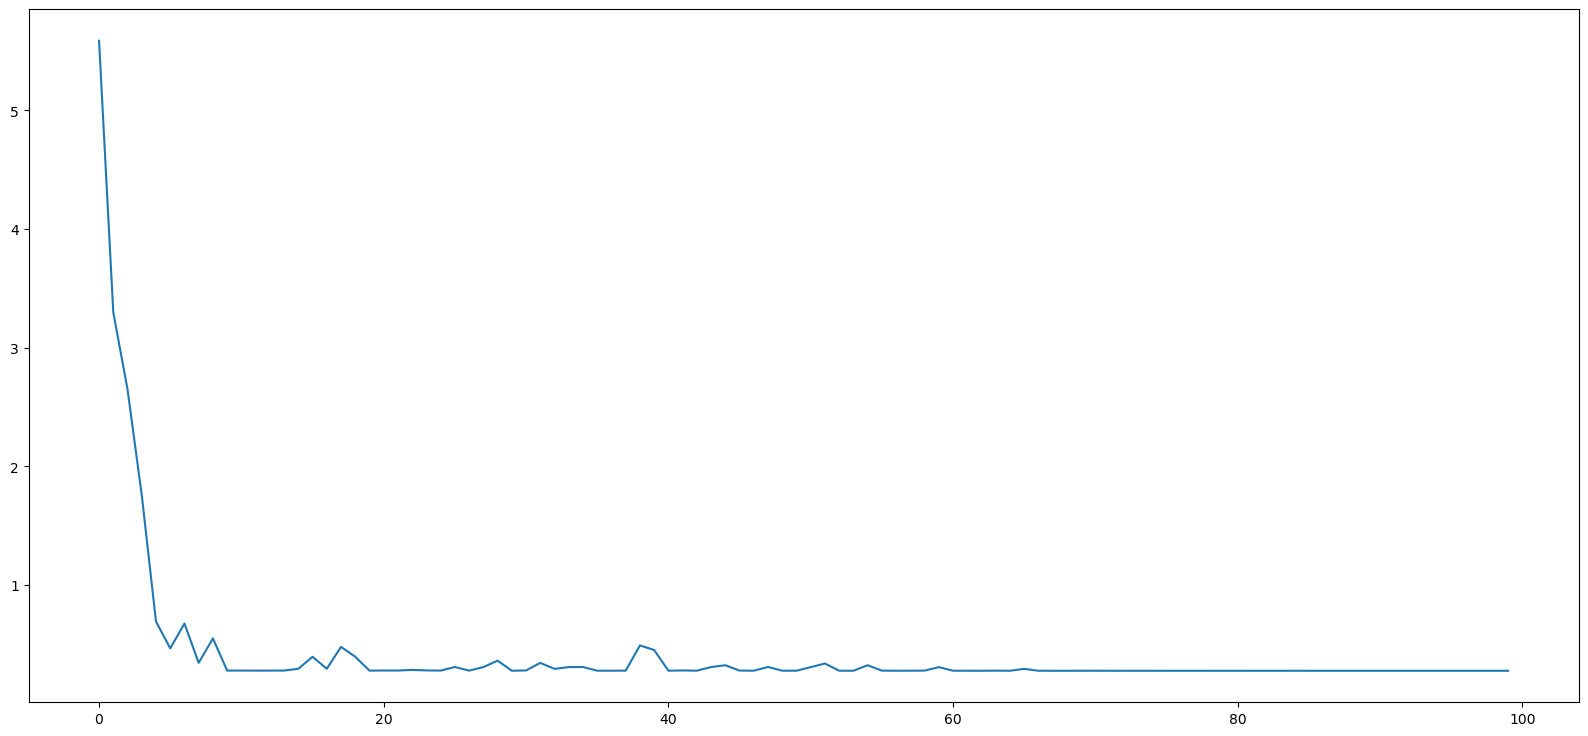

In [7]:
lr = 1e-2
n_epochs = 100
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)

model = Embedding_MLP(n_cont=len(cont_columns), layer_scaling=100)
loss_fct = nn.MSELoss()
opt = torch.optim.SGD(params=model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=opt, T_max=n_epochs)
log_loss = []
log_error = []

model = model.train().to(device)
for e in tqdm(range(n_epochs)):
    for x_cat, x_cont, y in dl_train:
        x_cat = x_cat.to(device)
        x_cont = x_cont.to(device)
        y = y.to(device)
        pred = model(x_cat, x_cont)
        loss = loss_fct(pred, y).mean()
        loss.backward()
        opt.step()
        opt.zero_grad()
    log_loss.append(loss.item())
    scheduler.step()
    model = model.eval()#.to(torch.device('cpu'))
    error = model.evaluate(dl_test, device=device)
    log_error.append(error)

# os.makedirs(args.paths.models_dir, exist_ok=True)
# torch.save(model.state_dict(), os.path.join(args.paths.models_dir, f'embedding_model_{args.n_files}_{args.embedding_dim}.pt'))

plt.figure(figsize=(20, 9))
plt.plot(log_error)
plt.show()

In [8]:
# for x_cat, x_cont, y in dl_train:
#     print(x_cat.min(), x_cat.max())
#     print(x_cont.min(), x_cont.max())
#     print(y.min(), y.max())

torch.Size([16, 48, 1])
torch.Size([16, 48, 2])
torch.Size([16, 48, 1])


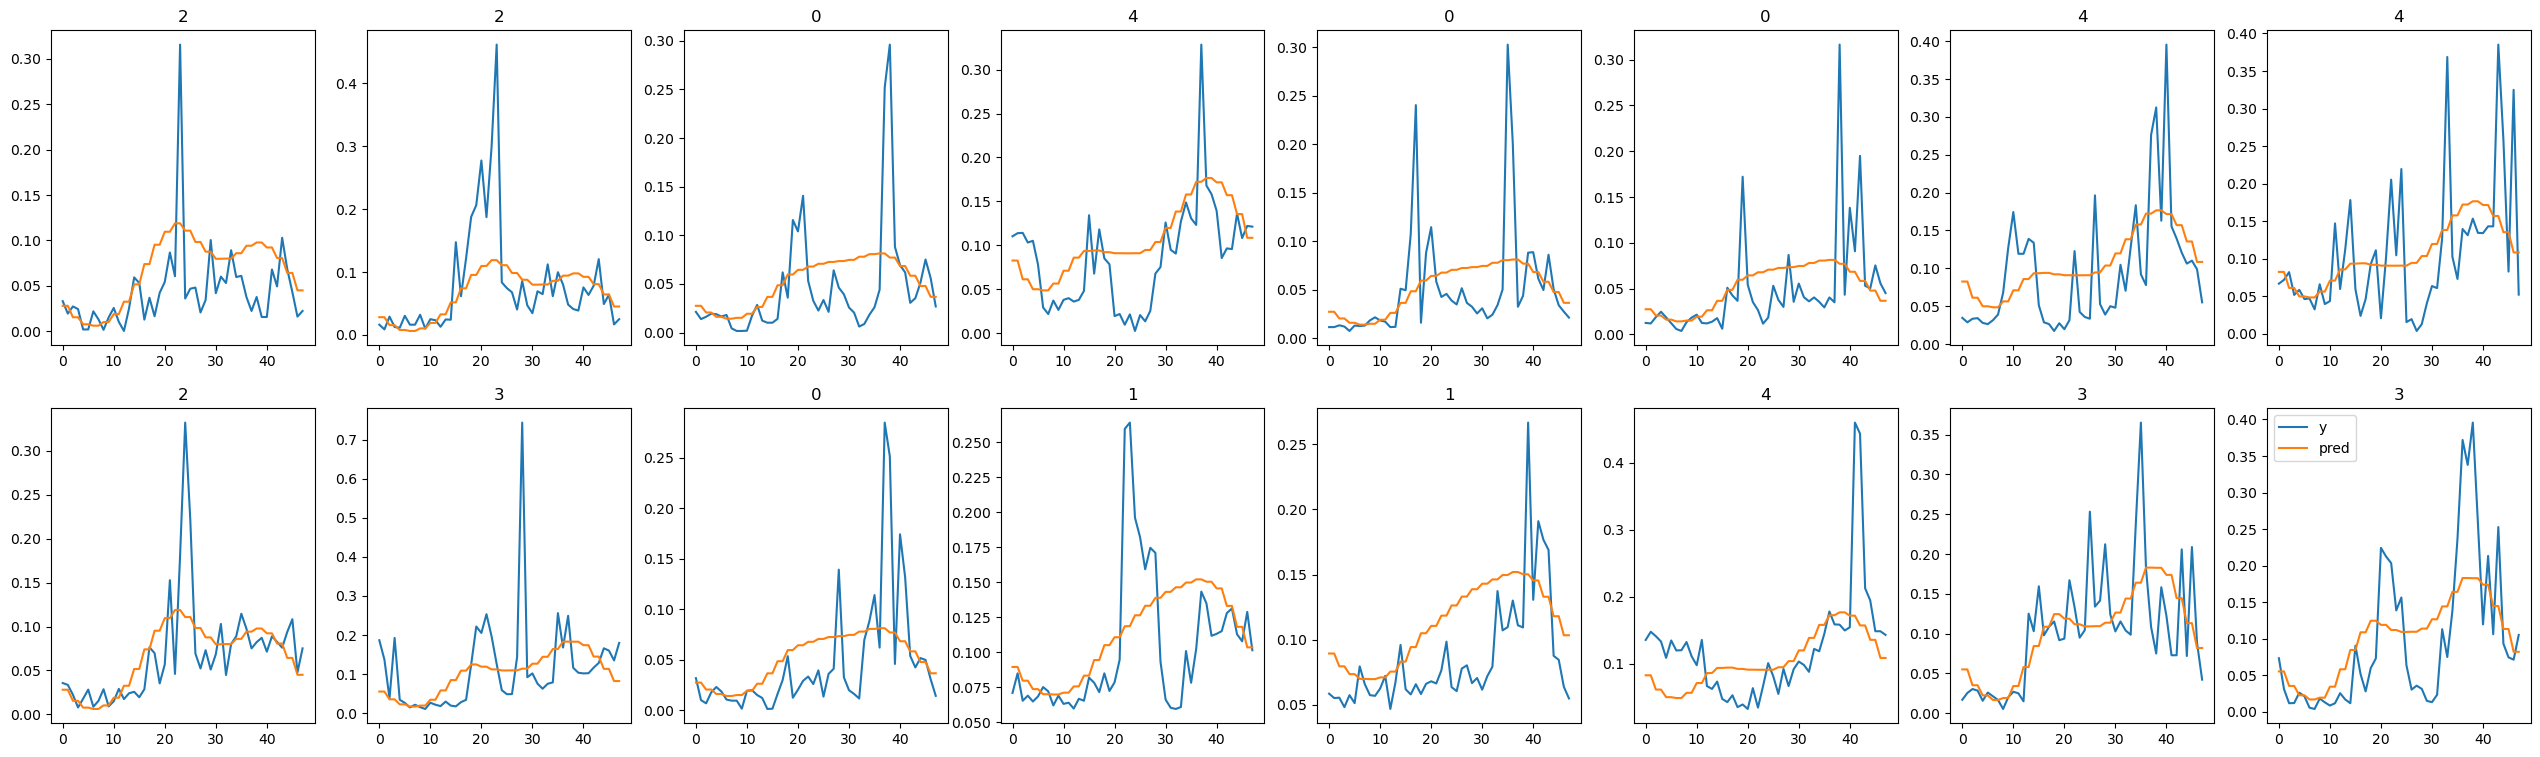

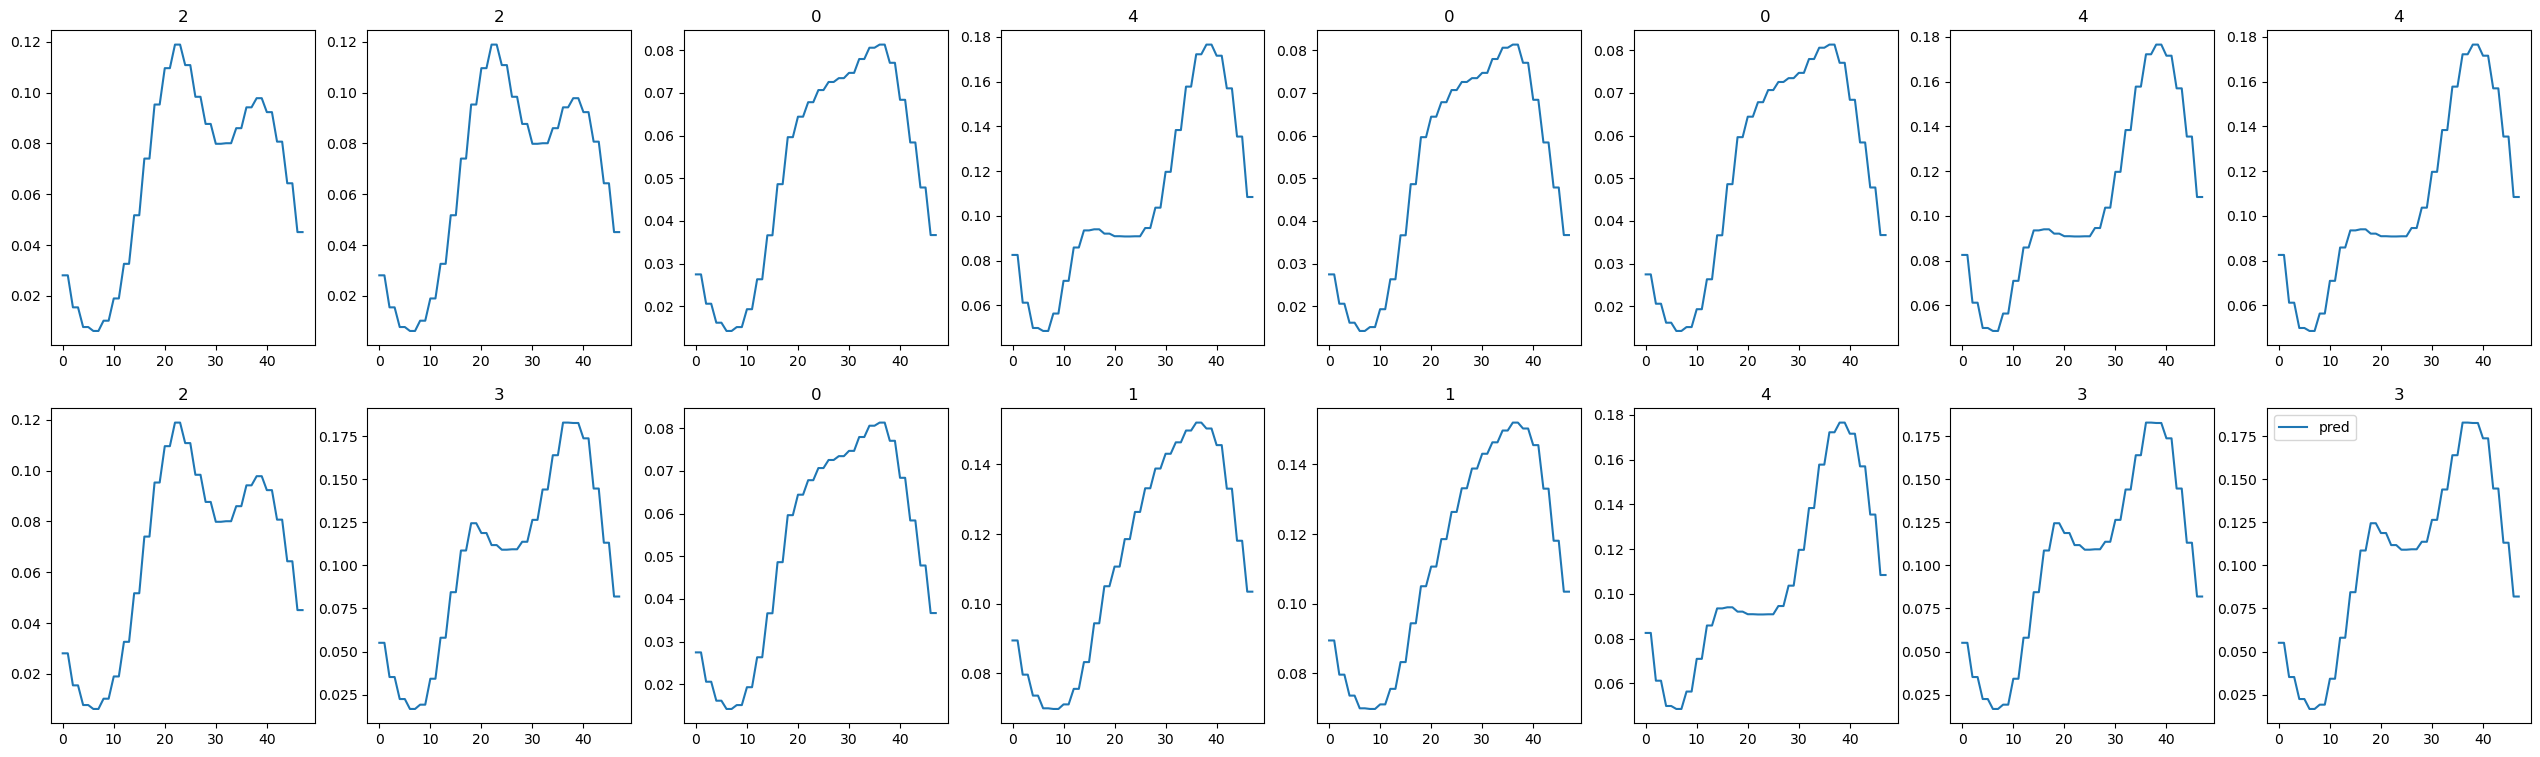

In [9]:
for x_cat, x_cont, y in dl_test:
    x_cat = x_cat.to(device)
    x_cont = x_cont.to(device)
    print(x_cat.shape)
    print(x_cont.shape)
    print(y.shape)
    pred = model(x_cat, x_cont).detach().cpu().numpy()
    break

plt.figure(figsize=(32, 9))
for batch_id in range(16):
    plt.subplot(2, 8, batch_id+1)
    plt.title(x_cat[batch_id, 0, 0].item())
    plt.plot(y[batch_id, :, 0], label='y')
    plt.plot(pred[batch_id, :, 0], label='pred')
plt.legend()
plt.show()

plt.figure(figsize=(32, 9))
for batch_id in range(16):
    plt.subplot(2, 8, batch_id+1)
    plt.title(x_cat[batch_id, 0, 0].item())
    # plt.plot(y[batch_id, :, 0], label='y')
    plt.plot(pred[batch_id, :, 0], label='pred')
plt.legend()
plt.show()

In [10]:
y.mean(), pred.mean(), y.var(), pred.var()

(tensor(0.0809), 0.08473978, tensor(0.0059), 0.0019367152)

In [11]:
# -> auxiliary gan?